## Статистический анализ метрик.

### Содержание:

* [1 - Построим гистограмму распределения каждой из метрик в датасете](#1)
* [2 - Для каждой метрики найдeм среднее, дисперсию, 50, 75 и 99 перцентили, моду, сделаем выводы о наличии аномалий](#2)
* [3 - Для каждой метрики проанализируем ассиметрию и смещенность распределения (посчитаем коэффициенты ассиметрии и эксцесса)](#3)
* [4 - Построим симметричный доверительный интервал для метрики с самой большой дисперсией при доверительной вероятности 0.95](#4)
* [5 - Найдем количество значений, выходящих за три сигмы для каждой из метрик (где получилось больше всего аномалий)](#5)
* [6 - Построим корреляционную матрицу и heatmap по метрикам, сделаем выводы о наличии связей](#6)

In [1]:
# Импортируем все необходимые библиотеки и настроим ноутбук:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
import statsmodels.api as sm
from scipy import stats
import scipy.special as sps
from scipy import *
import warnings

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

<a id='1'></a>

### 1 - Построим гистограмму распределения каждой из метрик в датасете.

In [2]:
# Загрузим датасет:

df = pd.read_csv("bikeshare.csv")
del df['datetime']
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


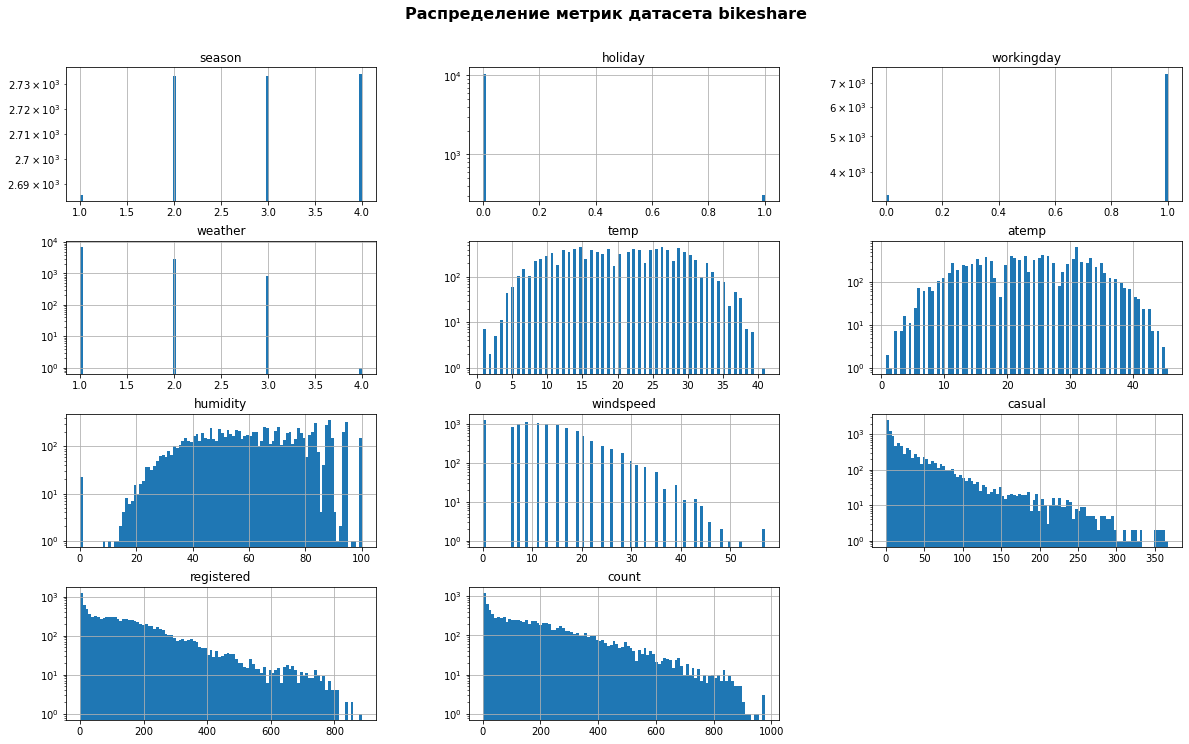

In [3]:
# Построим график:

fig, ax = plt.subplots(figsize=(20,12))
df.hist(bins=100, ax=ax, log=True)  # добавим логарифмированную ось
fig.suptitle("Распределение метрик датасета bikeshare", fontweight='bold', y = 0.95, fontsize=16)

plt.show()

<a id='2'></a>

### 2 - Для каждой метрики найдeм среднее, дисперсию, 50, 75 и 99 перцентили, моду, сделаем выводы о наличии аномалий.

In [4]:
# Напишем функцию, которая считает среднее, дисперсию, 50, 75, 99 перцентили и моду:

def my_basic_research(df=df, column=df.columns):
    
    print(column)
    print("------------------------------------")
    print("Среднее значение: ", df[column].mean())
    print("Дисперсия: ", df[column].var(ddof=1))
    print("50-й перцентиль (медиана): ", df[column].median())
    print("99-й перцентиль: ", np.percentile(df[column], 99, axis = 0)) 
    print("Самые популярные значения метрики (мода), топ 5:")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")

In [5]:
# Выведем эти метрики для всех признаков:

for feature in df.columns:
    my_basic_research(column=feature)

season
------------------------------------
Среднее значение:  2.5066139996325556
Дисперсия:  1.2458450888401458
50-й перцентиль (медиана):  3.0
99-й перцентиль:  4.0
Самые популярные значения метрики (мода), топ 5:
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
------------------------------------
holiday
------------------------------------
Среднее значение:  0.02856880396839978
Дисперсия:  0.02775517702947772
50-й перцентиль (медиана):  0.0
99-й перцентиль:  1.0
Самые популярные значения метрики (мода), топ 5:
0    10575
1      311
Name: holiday, dtype: int64
------------------------------------
workingday
------------------------------------
Среднее значение:  0.6808745177291935
Дисперсия:  0.21730437065606645
50-й перцентиль (медиана):  1.0
99-й перцентиль:  1.0
Самые популярные значения метрики (мода), топ 5:
1    7412
0    3474
Name: workingday, dtype: int64
------------------------------------
weather
------------------------------------
Среднее значение:  1

#### Какие выводы о наличии аномалий мы можем сделать?

* Схожие значения у среднего и медианы у признаков temp и atemp, эти распределения похожи на нормальные.
* У признака humidity так же близки медиана и среднее, но дисперсия намного больше, здесь, скорее всего, есть аномально высокие значения.
* Но точно говорить о наличии и количестве аномалий мы сможем после применения метода трёх сигм.

<a id='3'></a>

### 3 - Для каждой метрики проанализируем ассиметрию и смещенность распределения (посчитаем коэффициенты ассиметрии и эксцесса).

In [6]:
# Напишем функцию для расчета коэффициентов ассиметрии и эксцесса:

def kurtosis_skew(df=df, column=df.columns):
    
    print(column)
    print("------------------------------------")
    print("Эксцесс: ", kurtosis(df[column]))
    print("Ассиметрия: ", skew(df[column]))
    print("------------------------------------")

In [7]:
# Выведем коэффициенты для всех признаков:

for feature in df.columns:
    kurtosis_skew(column=feature)

season
------------------------------------
Эксцесс:  -1.3555899543299803
Ассиметрия:  -0.007074695296526289
------------------------------------
holiday
------------------------------------
Эксцесс:  30.032624417535125
Ассиметрия:  5.6597371332540805
------------------------------------
workingday
------------------------------------
Эксцесс:  -1.3977369782030475
Ассиметрия:  -0.7760560687198784
------------------------------------
weather
------------------------------------
Эксцесс:  0.39480007841067577
Ассиметрия:  1.2433126730817885
------------------------------------
temp
------------------------------------
Эксцесс:  -0.9146613849825282
Ассиметрия:  0.0036903358354289715
------------------------------------
atemp
------------------------------------
Эксцесс:  -0.8502363689497141
Ассиметрия:  -0.10254538108264065
------------------------------------
humidity
------------------------------------
Эксцесс:  -0.760019710012902
Ассиметрия:  -0.0863232869219358
-----------------------

**Коэффициент ассиметрии (skewness)** – характеризует смещенность распределения:
* Положителен, если правый хвост распределения длиннее левого, 
* отрицателен – если левый длиннее правого,
* нормального распределения равен 0.

**Коэффициент эксцесса (kurtosis)** - характеризует остроконечность распределения:
* Положительный при остром пике у среднего значения,
* отрицателен при гладком,
* у нормального распределения равен 0.

#### Описание:

* Итак, мы видим, что у признаков **season, workingday, atemp, humidity** коэффициенты ассиметрии и эксцесса отрицательные.
* Это значит, что левые хвосты у них длиннее правых и пики у среднего значения гладкие.


* У признаков **holiday, weather, windspeed, casual, registered и count** коэффициенты ассиметрии и эксцесса положительные. 
* Что говорит о том, что правые хвосты распределения у них длиннее левых и острых пиках у средних значений.


* У признака **temp** коэффициент ассиметрии положительный, а коэффициент эксцесса отрицательный, что говорит о том, что правый хвост распределения у него длиннее левого, а пик у среднего значения гладкий.


* Самые симметричные распределения у признаков **temp, atemp и humidity**, их коэффициенты ассиметрии и эксцесса близки к нулю.

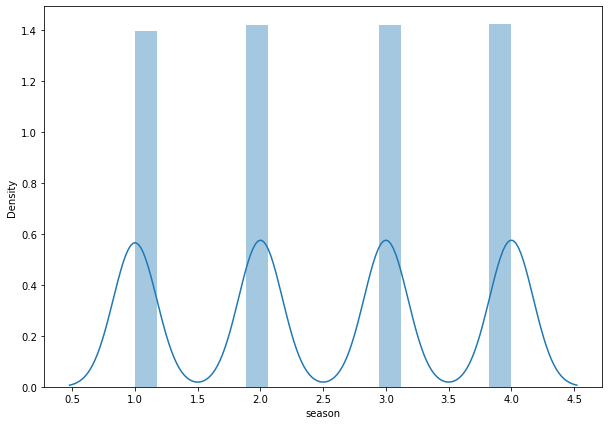

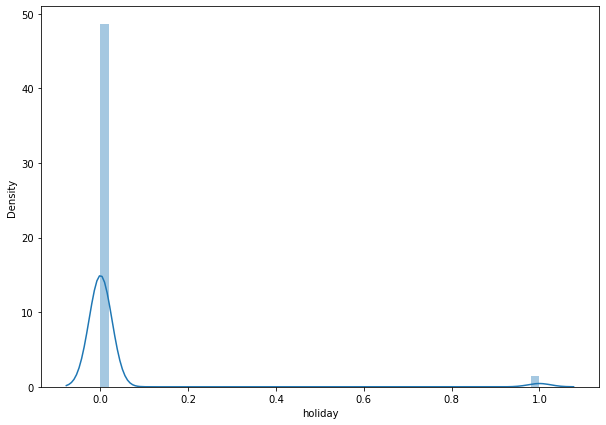

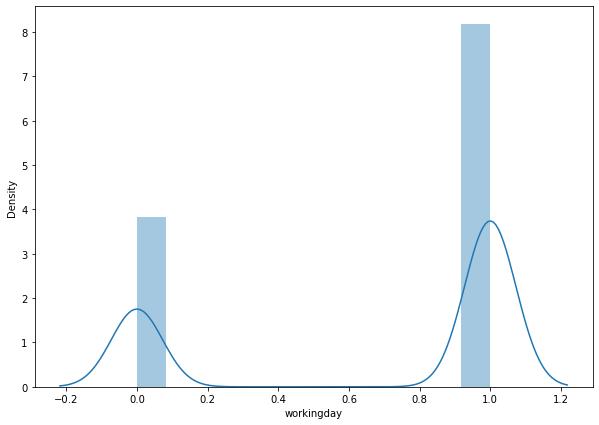

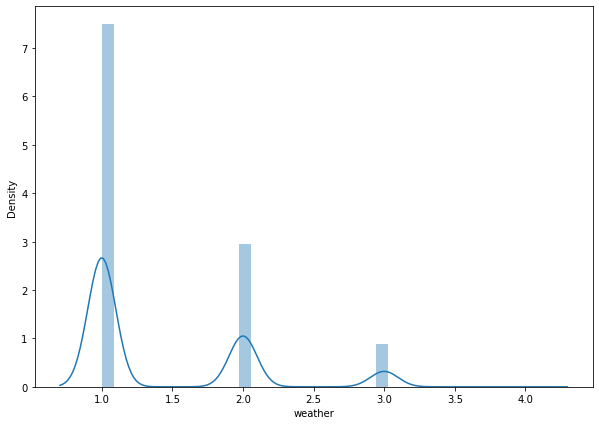

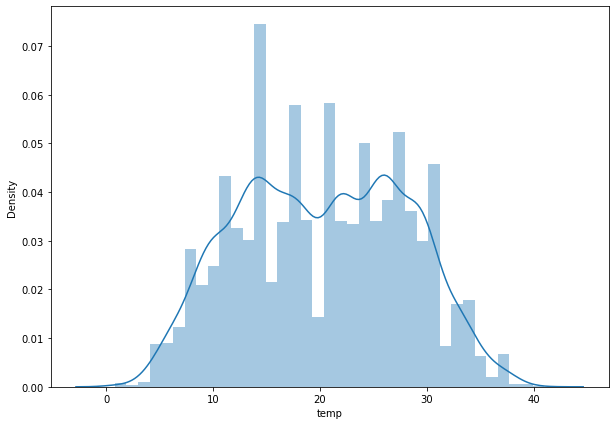

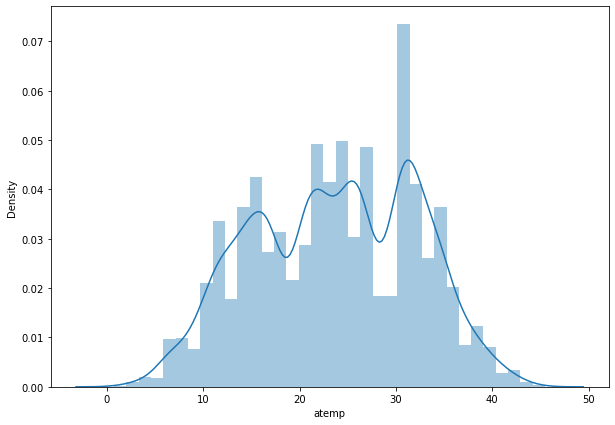

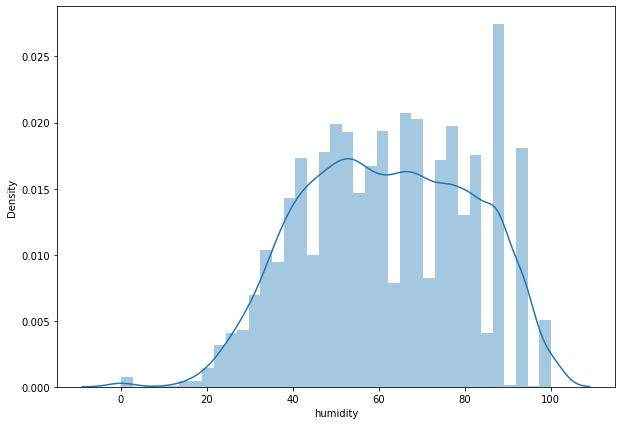

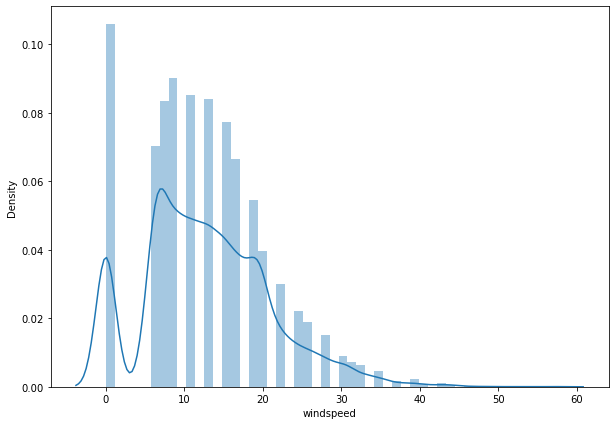

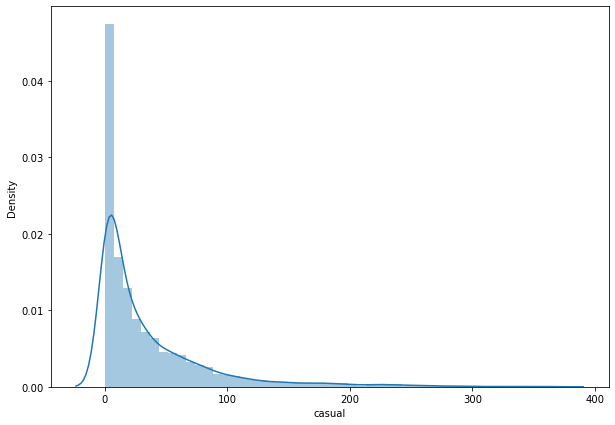

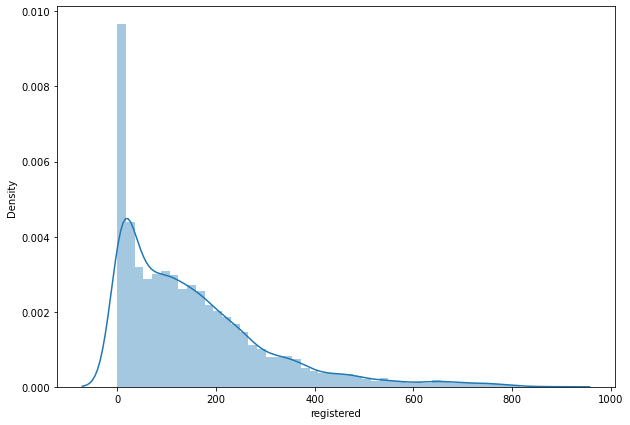

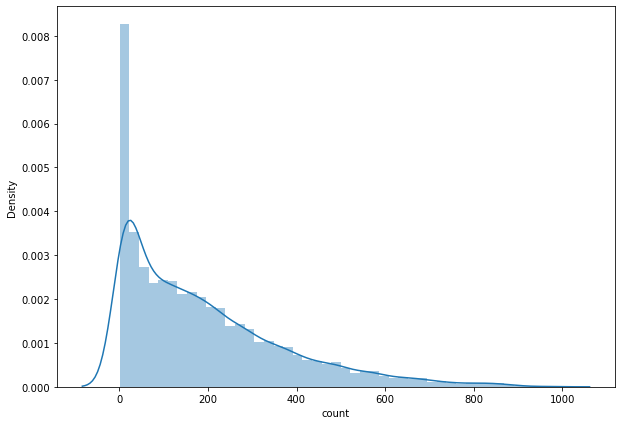

In [8]:
# Можем свериться с графиками:

for feature in df.columns:
    sns.distplot(df[feature])
    plt.show()    

<a id='4'></a>

### 4 - Построим симметричный доверительный интервал для метрики с самой большой дисперсией при доверительной вероятности 0.95. 

In [9]:
# Посмотрим, у какого признака самая большая дисперсия:

df.var(ddof=1)

season            1.245845
holiday           0.027755
workingday        0.217304
weather           0.401751
temp             60.708872
atemp            71.818856
humidity        370.371306
windspeed        66.659670
casual         2496.049219
registered    22812.789514
count         32813.313153
dtype: float64

* Самая большая дисперсия у признака count: 32813.313153
* Но для построения доверительного интервала необходимо, чтобы исследумая величина была распределена по Гауссову закону.
* Мы видим два распределения, больше всего похожих на нормальное - у признаков temp и atemp.
* Поэтому построим симметричный 95% доверительный интервал для признака atemp, так как у него дисперсия больше.

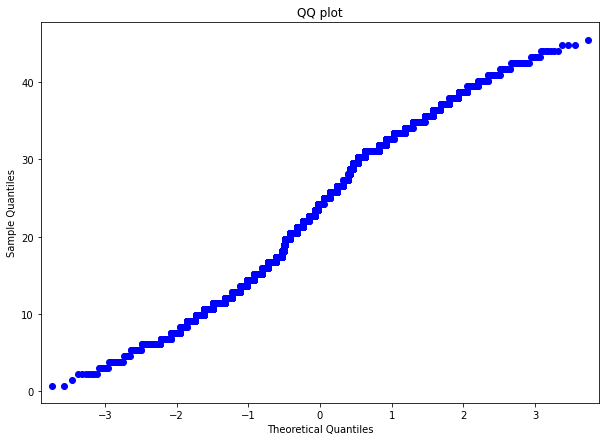

In [10]:
# Проверим распределение на нормальность при помощи графика QQ plot.
# График сравнивает квантили выборки и выбранноого распределения.
# И если они на графике располагаются под 45 градусов, то значит данные распределены по нормальному закону.

sm.qqplot(df['atemp'])
plt.title("QQ plot")
plt.show()

In [11]:
# Кажется, что можно использовать стандартные доверительные интервалы для нормального распределения.
# Для этого воспользуемся функцией:

def my_norm_confidence(df=df, column = "atemp", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

confidence = my_norm_confidence()
print(confidence)

(7.045172041640964, 40.26499606418288)


Text(0.5, 1.0, 'Доверительный интервал')

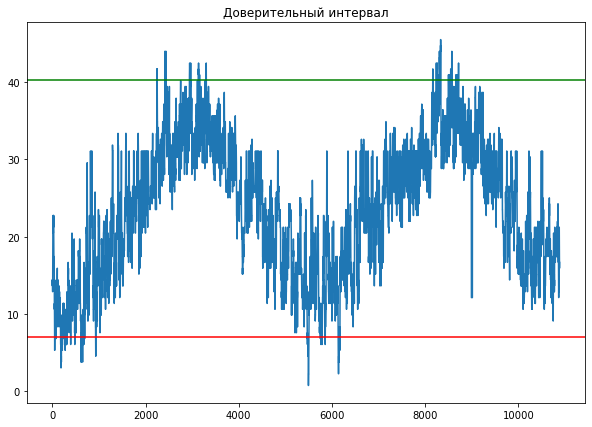

In [12]:
# При доверительной вероятности 95 % среднее значение atemp не выйдет за этот интервал. 
# Отметим на графике полученный коридор:

df['atemp'].plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

<a id='5'></a>

### 5 - Найдем количество значений, выходящих за три сигмы для каждой из метрик (где получилось больше всего аномалий).

In [13]:
# Метод трех сигм используется для нормальных распределений.
# Поэтому применим его к признакам temp и atemp, у которых распределения больше всего похожи на нормальные:

# temp:
upper_level = df.temp.mean() + 3*df.temp.std()
lower_level = df.temp.mean() - 3*df.temp.std()
print(lower_level, upper_level)

-3.1439097120103447 43.605629351914686


In [14]:
# atemp:
upper_level_a = df.atemp.mean() + 3*df.atemp.std()
lower_level_a = df.atemp.mean() - 3*df.atemp.std()
print(lower_level_a, upper_level_a)

-1.7687178265427441 49.07888593236659


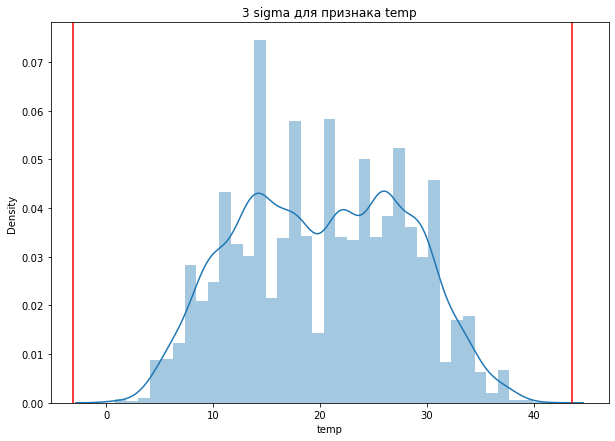

In [15]:
# Нарисуем полученный коридор на графике:

# temp:
sns.distplot(df.temp)
plt.axvline(x=lower_level, color="r", linestyle="-")
plt.axvline(x=upper_level, color="r", linestyle="-")
plt.title("3 sigma для признака temp")
plt.show()

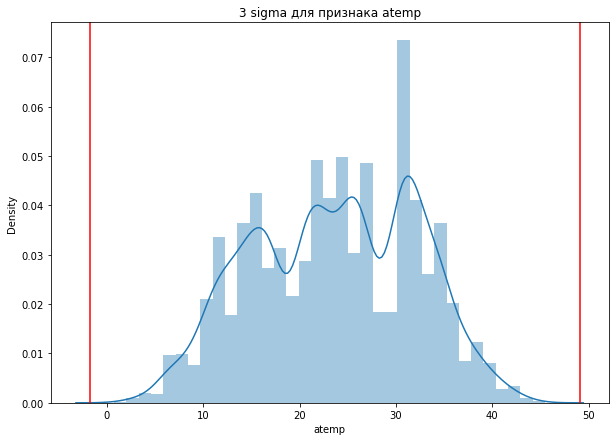

In [16]:
# atemp:
sns.distplot(df.atemp)
plt.axvline(x=lower_level_a, color="r", linestyle="-")
plt.axvline(x=upper_level_a, color="r", linestyle="-")
plt.title("3 sigma для признака atemp")
plt.show()

In [21]:
# Напишем функцию, которая считает количество значений, выходящих за три сигмы:

def find_anomaly(df, column):
    upper_level = df[column].mean() + 3 * df[column].std()
    lower_level = df.temp.mean() - 3 * df.temp.std()
    anomaly = df[(df[column] >= upper_level) ^ (df[column] <= lower_level)]
    return len(anomaly)

In [22]:
# Выведем кол-во значений, выходящих за три сигмы для каждой из метрик
# (с небольшими оговорками метод трёх сигм можно применять и для ненормально распределённых величин)

for feature in df.columns:
    anomaly = find_anomaly(df=df, column=feature)
    print(f'{feature}: {anomaly}')


season: 0
holiday: 311
workingday: 0
weather: 1
temp: 0
atemp: 0
humidity: 0
windspeed: 67
casual: 292
registered: 235
count: 147


#### Как видим, больше всего аномалий у признаков:

* holiday: 311
* casual: 292
* registered: 235

<a id='6'></a>

### 6 - Построим корреляционную матрицу и heatmap по метрикам, сделаем выводы о наличии связей.

In [19]:
# Построим корреляционную матрицу:

corr_m = df.corr()
corr_m

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


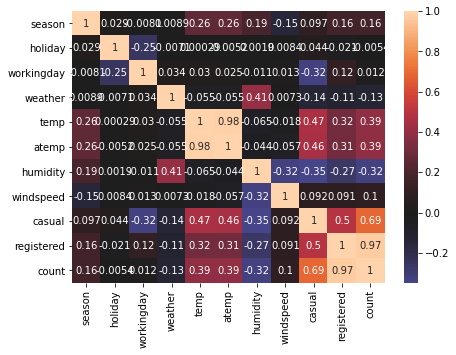

In [20]:
# Визуализируем полученную матрицу:

plt.figure(figsize=(7,5))
sns.heatmap(corr_m, center=0, annot=True)
plt.show()

### Шкала Чеддока:

* 0,1 - 0,3: Слабая связь
* 0,3 - 0,5: Умеренная связь
* 0,5 - 0,7: Заметная связь
* 0,7 - 0,9: Высокая связь
* 0,9 - 0,99: Весьма высокая связь

### Выводы:

#### Весьма высокая связь между признаками:
* temp и atemp (0.98) 
* registered и count - (0.97)

#### Заметная связь между признаками: 
* casual и count (0.69)

#### Умеренные связи между признаками: 
* casual и temp (0.47)
* casual и atemp (0.46)
* humidity и weather (0.41)
* count и atemp (0.39)
* count и temp (0.39)
* casual и humidity (0.35)
* count и humidity (0.32)
* windspeed и humidity (0.32)
* workingday и casual (0.32)
* temp и registered (0.32).